# Distributed Variational Quantum Eigensolver Based on Schmidt Decomposition
*Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

## Overview

Retrieving ground state information of a Hamiltonian in amongst the essential questions in physics and chemistry. Currently, it is widely believed that quantum computers are advantageous in solving this kind of problem. As one of the promising algorithms to demonstrate quantum supremacy in the near term, [Variational Quantum Eigensolver (VQE)](https://qml.baidu.com/tutorials/quantum-simulation/variational-quantum-eigensolver.html)
enables the study of quantum chemistry on Noisy Intermediate-Scale Quantum (NISQ) devices. However, various technical limitations still exist on current NISQ hardware, forbidding the deployment of large-scale quantum algorithms. For example, limited by the number of available qubits, researchers have not been able to simulate realistic large molecules with high precision. To overcome this barrier, researchers have proposed a wide range of distributed strategies [1-3]. In this tutorial, we take the distributed VQE based on Schmidt decomposition, proposed in [4], as an example to demonstrate how to implement distributed quantum algorithms using Paddle Quantum.

## Schmidt Decomposition
We start with the following trivial decomposition for any pure state $|\psi\rangle$ of a composite system $AB$:

$$
|\psi\rangle=\sum_{ij}a_{ij}|i\rangle\otimes|j\rangle,
\tag{1}
$$

where $|i\rangle$ and $|j\rangle$ are computational bases of subsystems $A$ and $B$ respectively, and $a_{ij}$ are elements of some complex matrix $a$. Then, we apply [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition)
on $a$, i.e., $a = udv$ with $u,v$ being unitary and $d$ diagonal. Hence, $a_{ij}=\sum_ku_{ik}d_{kk}v_{kj}$. 

By defining

$$
\begin{aligned}
|k_A\rangle\equiv & \sum_iu_{ik}|i\rangle=u|k\rangle,\\
|k_B\rangle\equiv & \sum_jv_{kj}|j\rangle=v^T|k\rangle,\\
\lambda_k\equiv & d_{kk},
\end{aligned}
\tag{2}
$$

we may rewrite Eq. (1) as

$$
\begin{aligned}
    |\psi\rangle  &= \sum_{ijk}u_{ik}d_{kk}v_{kj}|i\rangle\otimes|j\rangle \\
                &= \sum_{k}\lambda_{k}\Big(\sum_iu_{ik}|i\rangle\Big)\otimes\Big(\sum_jv_{kj}|j\rangle\Big) \\
                &=\sum_{k}\lambda_k(u|k\rangle\otimes v^T|k\rangle)\\
                &=\sum_{k}\lambda_k|k_A\rangle\otimes|k_B\rangle.
\end{aligned}
\tag{3}
$$

The decomposition of $|\psi\rangle$ into the form of $\sum_k\lambda_k|k_A\rangle\otimes|k_B\rangle$ is known as its ***Schmidt decomposition*** [5], with $\{\lambda_k\}_k$ called the *Schmidt coefficients* and the number of non-zero $\lambda_k$'s its *Schmidt rank*. In fact, the property of SVD also guarantees that $\lambda_k\in\mathbb{R}^+$ and $\sum_k\lambda_k^2=1$. 

## Distributed VQE Based on Schmidt Decomposition

As a variation of the standard VQE [6], the distributed VQE also seeks to solve the ground state and its energy of an $N$-qubit Hamiltonian $\hat{H}=\sum_tc_t\hat{H}_t^{(A)}\otimes\hat{H}_t^{(B)}$， where $\hat{H}_t^{(A)},\hat{H}_t^{(B)}$ are Hamiltonian terms on subsystems $A,B$ respectively (we have assumed that $A$, $B$ both have $N/2$ qubits).

To start with, we write the trial wave function as

$$
|\psi\rangle\equiv\sum_{k=1}^S\lambda_k\Big(U(\boldsymbol{\theta})|k\rangle\Big)\otimes\Big(V(\boldsymbol{\phi})|k\rangle\Big),
\tag{4}
$$

for some $\boldsymbol{\lambda}\equiv(\lambda_1, \lambda_2,...,\lambda_S)^T$ and $1\leq S\leq 2^{N/2}$ a user-defined constant. According to Schmidt decomposition, the target ground state also has the form of Eq. (4) and hence can be approximated with high precision by choosing appropriate parameters $\boldsymbol{\lambda}, \boldsymbol{\theta}$ and $\boldsymbol{\phi}$.

Now, for all $i,j=1,...,S$, we evaluate the following terms on an $N/2$-qubit quantum computer:

$$
\begin{aligned}
E_{ijt}^A(\boldsymbol{\theta}) &\equiv \langle i|U^\dagger(\boldsymbol{\theta}) \hat{H}_t^{(A)} U(\boldsymbol{\theta})|j\rangle,\\
E_{ijt}^B(\boldsymbol{\phi}) &\equiv \langle i|V^\dagger(\boldsymbol{\phi}) \hat{H}_t^{(B)} V(\boldsymbol{\phi}))|j\rangle.
\end{aligned}
\tag{5}
$$

Then, on a classical computer, we construct an $S\times S$ dimensional matrix $M(\boldsymbol{\theta},\boldsymbol{\phi})$ according to

$$
[M(\boldsymbol{\theta},\boldsymbol{\phi})]_{ij}\equiv\sum_tc_tE_{ijt}^A(\boldsymbol{\theta})E_{ijt}^B(\boldsymbol{\phi}).
\tag{6}
$$

In this way, the target ground state energy can be written as  
$$
\begin{aligned}
E_{tar}   &= \min_{\boldsymbol{\lambda}, \boldsymbol{\theta}, \boldsymbol{\phi}} \langle{\psi}|\hat{H}|\psi\rangle \\
    &= \min_{\boldsymbol{\lambda}, \boldsymbol{\theta}, \boldsymbol{\phi}}\Big(\sum_{i,j=1}^S\lambda_i\lambda_j[M(\boldsymbol{\theta},\boldsymbol{\phi})]_{ij}\Big)\\
    &= \min_{\boldsymbol{\theta}, \boldsymbol{\phi}} E(\boldsymbol{\theta},\boldsymbol{\phi}),
\end{aligned}
\tag{7}
$$

where $E(\boldsymbol{\theta},\boldsymbol{\phi})\equiv\min_{\boldsymbol{\lambda}} \boldsymbol{\lambda}^T M(\boldsymbol{\theta},\boldsymbol{\phi})\boldsymbol{\lambda}$. By linear algebra, we see that $E(\boldsymbol{\theta},\boldsymbol{\phi})$ is exactly the minimal eigenvalue of $M(\boldsymbol{\theta},\boldsymbol{\phi})$, which can be solved using classical algorithms.

Finally, we repeat the whole process and minimize $E(\boldsymbol{\theta},\boldsymbol{\phi})$ to approximate $E_{tar}$ using gradient-based optimization methods.

## Paddle Quantum implementation

First of all, we import necessary packages. Please make sure that you have *PaddlePaddle* >= 2.2.0 and *Paddle Quantum* >= 2.1.3, as we will use some of their latest features.

In [11]:
import time
import numpy as np
from matplotlib import pyplot as plt

import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix, schmidt_decompose

Define some global constants:

In [12]:
N = 10      # Number of qubits
SEED = 16   # Fix a random seed
ITR = 100   # Set the number of learning iterations
LR = 0.1    # Set the learning rate
D = 3       # Set the depth for QNN

The following function classically calculates the ground state information (the energy and the Schmidt rank of the ground state) of a Hamiltonian $H$, which we will use as the ground truth to benchmark our quantum models.

In [13]:
def get_ground_state_info(H):

    # Calculate the eigenvalues and eigenvectors of H
    vals, vecs = paddle.linalg.eigh(H)
    # Retrieve the ground state
    ground_state = vecs[:, 0].numpy()
    # Retrieve the ground state energy
    ground_state_energy = vals.tolist()[0]
    print(f'The ground state energy is {ground_state_energy:.5f} Ha.')
    # Run Schmidt decomposition on the ground state.
    l, _, _ = schmidt_decompose(ground_state)
    print(f'Schmidt rank of the ground state is {l.size}.')

    return ground_state_energy

Now, we generate a Hamiltonian and calculate its ground state information.

In [14]:
# Fix a random seed
np.random.seed(SEED)

# Hard code a random a Hamiltonian
coefs = [-0.8886258, 0.453882]
pauli_str = ['x0,z1,z2,z4,x5,y6,y7,x8,x9', 'y0,x1,x2,x3,y4,x5,z6,z7,y8,x9']
pauli_str_A = ['x0,z1,z2,z4', 'y0,x1,x2,x3,y4']     # pauli substring for system A
pauli_str_B = ['x0,y1,y2,x3,x4', 'x0,z1,z2,y3,x4']  # pauli substring for system B

# Convert relavent object into Tensor form
H_mtr = paddle.to_tensor(pauli_str_to_matrix(zip(coefs, pauli_str), n=N))
coefs = paddle.to_tensor(coefs)
H_A = [pauli_str_to_matrix([[1., pstr]], n=N//2) for pstr in pauli_str_A]
H_A = paddle.to_tensor(np.stack(H_A))
H_B = [pauli_str_to_matrix([[1., pstr]], n=N-N//2) for pstr in pauli_str_B]
H_B = paddle.to_tensor(np.stack(H_B))

# calculate the ground state information
ground_state_energy = get_ground_state_info(H_mtr)

The ground state energy is -0.99783 Ha.
Schmidt rank of the ground state is 3.


Now that we have prepared a Hamiltonian, we may build a distributed VQE to solve it.

In [15]:
# Construct parameterized circuit
def U_theta(param, N, D):
    
    cir = UAnsatz(N)  # Initialize an N-qubit-width circuit
    cir.complex_entangled_layer(param, D)   # Add quantum gates
    return cir.U  # Retrieve the unitary matrix for the parameterized circuit

# Apply a parameterized circuit on the conputational bases
# and return a tensor of shape [2**N, num_states]
def output_states(theta, num_states, N, D):
    # Create num_states-many computational bases
    basis = paddle.eye(2**N, num_states)
    
    # Acquire a parameterized circuit
    U = U_theta(theta, N, D)
    
    # Apply the parameterized circuit on these bases
    vec = U @ basis                         
    
    return vec

The code below is core to this tutorial. Please compare them with the formulae given in the beginning section and make sure that they are well understood.

In [16]:
# Construct the distributed model
class DistributedVQE(paddle.nn.Layer):
    def __init__(self, N, D, S):
        super().__init__()
        paddle.seed(SEED)

        # Define constant S
        self.S = S
        self.N, self.D = N, D
        # Initialize the parameter lists theta, phi, filled by a uniform distribution in [0, 2*pi]
        self.theta = self.create_parameter(shape=[D, N//2, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        self.phi = self.create_parameter(shape=[D, N - N//2, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        
    # The core logic of distributed VQE
    def forward(self):
        # Obtain U|k> and V|k> for subsystems A and B respectively 
        vec_A = output_states(self.theta, self.S, self.N//2, self.D)
        vec_B = output_states(self.phi, self.S, self.N - self.N//2, self.D)
        
        # Calculate tensor E_A, E_B, which have elements E_{ijt}^A and E_{ijt}^B, as per defined in above
        E_A = vec_A.conj().t() @ H_A @ vec_A
        E_B = vec_B.conj().t() @ H_B @ vec_B
        M = (coefs.reshape([-1, 1, 1]) * E_A * E_B).sum(0)

        # Find the minimal eigenvalue of M
        eigval = paddle.linalg.eigvalsh(M)
        loss = eigval[0]
        
        return loss

Define training function.

In [17]:
def train(model):
    start_time = time.time()    # To calculate the running time of this function
    
    # We will use Adam, a gradient-based optimizer to optimize theta and phi
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    summary_loss = []           # Save loss history

    # Optimization iteration
    for itr in range(ITR):

        # Forward propagation to calculates the loss function
        loss = model()

        # Backward propagation to optimize the loss function
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()

        # Update optimization result
        summary_loss.append(loss.numpy())

        # Print itermediary result
        if (itr+1) % 20 == 0:
            print(f"iter: {itr+1}, loss: {loss.tolist()[0]: .4f} Ha")

    print(f'Ground truth is  {ground_state_energy:.4f} Ha')
    print(f'Training took {time.time() - start_time:.2f}s')
    
    plt.plot(list(range(ITR)), summary_loss, color='r', label='loss')
    plt.hlines(y=ground_state_energy, xmin=0, xmax=ITR, linestyle=':',  label='ground truth')
    plt.legend()
    plt.title(f'Loss for {type(model).__name__} on a {N}-qubit Hamiltonian')
    plt.show()

Now, we are ready to instantiate the model and train it!

iter: 20, loss: -0.9244 Ha
iter: 40, loss: -0.9906 Ha
iter: 60, loss: -0.9968 Ha
iter: 80, loss: -0.9977 Ha
iter: 100, loss: -0.9978 Ha
Ground truth is  -0.9978 Ha
Training took 13.01s


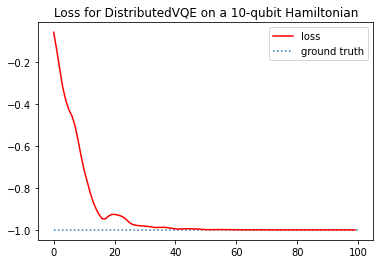

In [18]:
# Note that we manually set S = 4 as the Hamiltonian we just created interacts weakly across the subsystems.
# (See the Conclusion section for further description)
vqe = DistributedVQE(N, D, S=4)
train(vqe)

We have plotted the actual ground state energy as a dotted line in the figure above. We see that the loss curve converges to the dotted line, meaning that our distributed VQE successfully found the ground state energy of the Hamiltonian. However, to properly evaluate our model, we need to compare it with the standard VQE, which we build below:

In [19]:
class StandardVQE(paddle.nn.Layer):
    def __init__(self, N, D):
        super().__init__()
        paddle.seed(SEED)
        self.N, self.D = N, D
        self.theta = self.create_parameter(shape=[D, N, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        
    def forward(self):
        vec = output_states(self.theta, 1, self.N, self.D)
        loss = vec.conj().t() @ H_mtr @ vec
        return loss.cast('float64').flatten()

Instantiate and train the StandardVQE.

iter: 20, loss: -0.8365 Ha
iter: 40, loss: -0.9852 Ha
iter: 60, loss: -0.9958 Ha
iter: 80, loss: -0.9975 Ha
iter: 100, loss: -0.9978 Ha
Ground truth is  -0.9978 Ha
Training took 721.76s


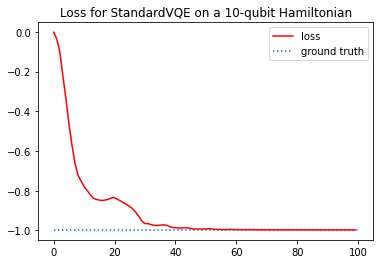

In [ ]:
svqe = StandardVQE(N, D)
train(svqe)  # Train the standard VQE 

Interestingly, by comparing the running time of the two models, we find that the distributed model runs 50 times faster than the standard VQE! In fact, this is easy to understand: in a distributed model, we only need to simulate two $N/2$-qubit unitary transformations, which is, of course, much more time- and space-efficient than simulating an $N$-qubit unitary transformation in the standard VQE.

## Conclusion

In this tutorial, we built a distributed VQE and demonstrated some of its advantages:
- The capability of NISQ devices is expanded. Distributed strategies enable the deployment of quantum algorithms which require qubits that exceed the capability of current hardware.
- The computation efficiency is improved. For classical simulation of quantum processes, distributed algorithms reduce the dimension of unitary matrices, hence reducing the space and time cost for simulating them.

In the meantime, one must note that $S$, as a user-defined constant, plays a key role in the training accuracy and efficiency:
- For Hamiltonians which encode weak inter-subsystem interactions, their ground states are weakly entangled across the subsystems [7]. Hence, the Schmidt ranks are small and can be accurately and efficiently simulated by a small $S$. In fact, our example and most physically and chemically interesting Hamiltonians fall into this category.
- In contrast, for Hamiltonians which encode strong inter-subsystem interactions, their ground states are strongly entangled. Hence, a large $S$ may be required. But anyway, $S$ is upper-bounded by $2^{N/2}$ and thus the dimension of $M$ is upper-bounded by $2^{N/2}\times2^{N/2}$, which is still much smaller than the dimension of the initial Hamiltonian ($2^{N}\times 2^{N}$). Consequently, the efficiency of this algorithm is always better than the purely classical simulation.

_______

# References

[1] Fujii, Keisuke, et al. "Deep Variational Quantum Eigensolver: a divide-and-conquer method for solving a larger problem with smaller size quantum computers." [arXiv preprint arXiv:2007.10917 (2020)](https://arxiv.org/abs/2007.10917).

[2] Zhang, Yu, et al. "Variational Quantum Eigensolver with Reduced Circuit Complexity." [arXiv preprint arXiv:2106.07619(2021)](https://arxiv.org/abs/2106.07619).

[3] Peng, Tianyi et al. "Simulating Large Quantum Circuits On A Small Quantum Computer". [Physical Review Letters 125.15, (2020): 150504](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.150504).

[4] Eddins, Andrew, et al. "Doubling the size of quantum simulators by entanglement forging." [arXiv preprint arXiv:2104.10220 (2021)](https://arxiv.org/abs/2104.10220).

[5] Nielsen, Michael A., and Isaac L. Chuang. Quantum Computation and Quantum Information. Cambridge University Press, 2010.

[6] Moll, Nikolaj, et al. "Quantum optimization using variational algorithms on near-term quantum devices." [Quantum Science and Technology 3.3 (2018): 030503](https://iopscience.iop.org/article/10.1088/2058-9565/aab822).

[7] Khatri, Sumeet, and Mark M. Wilde. "Principles of quantum communication theory: A modern approach." [arXiv preprint arXiv:2011.04672 (2020)](https://arxiv.org/abs/2011.04672).